# Import libraries

In [1]:
# basics :
import pandas as pd
import numpy as np
from numpy import*
import datetime

# plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# impute and scale data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import train_test_split
# metrics
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
# save models
from sklearn.externals import joblib

/home/j/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Read data

In [3]:
dfm = pd.read_csv('train.csv', sep=",")
dfp = pd.read_csv('test.csv', sep=",")
df = pd.concat([dfm, dfp]) # I do not reset_index 
vardescr = pd.read_excel('case-intro/variabledescr.xlsx')

vardescr.columns = vardescr.columns.str.lower()

dataframes = [dfm, dfp, df]
for d in dataframes:
    d.columns = d.columns.str.lower()

df['y'] = df['approved']
dfm['y'] = dfm['approved']
df.drop('approved', inplace=True, axis=1)
dfm.drop('approved', inplace=True, axis=1)

In [4]:
df.shape, dfm.shape, dfp.shape

((99750, 22), (69713, 22), (30037, 21))

In [5]:
set(df.columns) - set(dfp.columns)

{'y'}

# Inspect and clean

In [8]:
print(vardescr.loc[:, ['column', 'type']])

                                 column         type
0                                    id       Object
1                                gender      Boolean
2                                   dob         Date
3                    lead_creation_date         Date
4                             city_code  Categorical
5                         city_category  Categorical
6                         employer_code  Categorical
7                    employer_category1  Categorical
8                    employer_category2  Categorical
9                        monthly_income    Numerical
10  customer_existing_primary_bank_code  Categorical
11                    primary_bank_type      Boolean
12                            contacted      Boolean
13                               source  Categorical
14                      source_category  Categorical
15                         existing_emi    Numerical
16                          loan_amount    Numerical
17                          loan_period    Num

In [9]:
# infer dtype
def getcoltype(type):
    '''Input string of type. Output list of colnames with that type. 
    Types can be Numerical, Categorical, Boolean, Object
    '''
    return vardescr.loc[vardescr.type == type, 'column'].tolist()

# save to list based on dtype
cols_datetime = getcoltype('Date')
cols_numeric = getcoltype('Numerical')
cols_category = getcoltype('Categorical')
cols_object = getcoltype('Object')
cols_boolean = getcoltype('Boolean')

In [10]:
# convert categorical, numerical, datetime
df[cols_numeric] = df[cols_numeric].apply(lambda x: pd.to_numeric(x))
df[cols_datetime] = df[cols_datetime].apply(lambda x: pd.to_datetime(x))
df[cols_category] = df[cols_category].apply(lambda x: x.astype('category'))

In [11]:
# convert booleans
df['female'] = (df.gender == 'Female')
df['primary_bank_type_G'] = (df.primary_bank_type == 'G')
df['contacted'] = (df.contacted == 'Y')
df.drop(['gender', 'primary_bank_type'], inplace = True, axis=1)
cols_boolean = ['female', 'primary_bank_type_G', 'contacted']

In [12]:
# create age 
df['age'] = 2018 - df.dob.dt.year
cols_numeric.append('age')

In [13]:
# based on descripe, fix age
df.loc[df.age < 0, 'age'] = np.nan

For both imputer and standardscaler the following is used: fit on `dfm`, use that fit to tranform `dfm`. Then use the same fit to transform `dfp`.

In [14]:
# rows 
rows_train_csv = df['y'].notnull()
rows_test_csv = ~rows_train_csv

In [15]:
# impute NA  for dfm and dfp
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
df.loc[rows_train_csv, cols_numeric] = imp.fit_transform(df.loc[rows_train_csv, cols_numeric])
df.loc[rows_test_csv, cols_numeric] = imp.transform(df.loc[rows_test_csv, cols_numeric])

In [16]:
# standardize for dfm and dfp
scaler = StandardScaler()
df.loc[rows_train_csv, cols_numeric] = scaler.fit_transform(df.loc[rows_train_csv, cols_numeric])
df.loc[rows_test_csv, cols_numeric] = scaler.transform(df.loc[rows_test_csv, cols_numeric])

# Fit and predict 

In [17]:
scoring = 'roc_auc'

## Choose X cols

List some options:

In [18]:
# ,'source',  and  'customer_existing_primary_bank_code' # has issues

cols_0 = ['monthly_income', 'contacted',
          'source_category',
          'var1', 'female', 'primary_bank_type_G']

# add a row
cols_1 = ['monthly_income', 'contacted',
          'source_category', 'var1', 'female', 'primary_bank_type_G',
          'age', 'employer_category1', 'employer_category2'
         ]

# like 1 but add financial
cols_1fin = ['monthly_income', 'contacted',
          'source_category', 'var1', 'female', 'primary_bank_type_G',
          'age', 'employer_category1', 'employer_category2'
          , 'existing_emi', 'loan_amount', 'loan_period', 'interest_rate' #financial
         ]

# based on DecisionTree() .feature_importances_ in another .py file:
cols_vip = ['monthly_income', 'existing_emi', 'interest_rate', 'loan_amount', 'age',
       'var1_10', 'employer_category1_C', 'source_category_F',
       'employer_category1_B', 'interest_rate']
# cols_vip is sorted!

In [19]:
# choose cols !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
cols_X = cols_1

## Convert X categoricals to dummies

In [20]:
X = pd.get_dummies(df[cols_X], drop_first = True)

In [21]:
# nr of cols is same or larger 
assert df[cols_X].shape[1] <= X.shape[1]

In [22]:
# X variables for dfm dfp
Xm = X[rows_train_csv]
Xp = X[rows_test_csv]

# y variables for dfm dfp and df
ym = df.loc[rows_train_csv, 'y']
yp = df.loc[rows_test_csv, 'y']
y = df['y']

# assert 
assert X.shape[0] == y.shape[0]
assert Xm.shape[0] + Xp.shape[0] == X.shape[0] # rows add upp 
assert Xm.shape[1] == Xp.shape[1] == X.shape[1] # same nr of cols

## Fit on X_train predict on X_test get roc auc score

In [23]:
# split 
X_train, X_test, y_train, y_test = train_test_split(Xm, ym, test_size=0.20, random_state=9)

In [24]:
# fit 
clf = GradientBoostingClassifier() # good roc auc

In [25]:
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [26]:
# predict
y_pred_proba = clf.predict_proba(X_test)[:, 1]
#y_pred_class = clf.predict(X_test)

In [27]:
roc_auc_score(y_test, y_pred_proba)
# 0.81778214617737444 with fit on X_train and test on y_test

0.81778214617737444

## Fit on Xm and predict on Xp

Refit on entire Xm rather than only X_train improves estimation

In [35]:
clf.fit(Xm, ym)
y_pred_proba_submit = clf.predict_proba(Xp)[:, 1]

# Submit 

rule: no NA in submission. rule: range is 0 to 1: min >= 0 max <= 1

In [36]:
test = pd.read_csv('test.csv')
pd.DataFrame({'ID':test['ID'], 
              'Approved':y_pred_proba_submit}
            ).set_index('ID').to_csv('submissions/submit.csv')

# Todo in the future

see do5todo.md

# Things that did not improve model performance

A list of attempts that did not improve the model performance wrt roc_auc

- A) impute most frequent rather than mean
- B) Grid search cv to tune my DecisionTree - the defaults were best
- C) Different classifiers: logistic regression, knn, random forests, 
- D) Using different classifiers with voting

## D) Voting

In [ ]:
clf_list = [DecisionTreeClassifier(),
            LogisticRegression(),
            KNeighborsClassifier(),
            GaussianNB(),
            SVC()]

eclf = VotingClassifier(estimators=[('a', clf_list[0]), 
                                    ('b', clf_list[1]), 
                                    ('c', clf_list[2])
                                   ]
                        , voting='soft')

eclf = eclf.fit(X_train, y_train)

print(roc_auc_score(y_test, eclf.predict_proba(X_test)[:, 1]))
# had .79 AUC for y_test

## B) cross validation using hyperparameters

## change threshold

In [37]:
from sklearn.metrics import f1_score

In [39]:
thresh = np.logspace(0, .01, 10)-1

list_score = []

for th in thresh:
    print(th*100, "%")
    y_pred_classed = y_pred_proba > th
    #print(confusion_matrix(y_test, y_pred_classed))
    score = f1_score(y_test, y_pred_classed)
    print(score.round(3))
    list_score.append(score)

0.0 %
0.032
0.256170345056 %
0.047
0.512996922568 %
0.054
0.77048141361 %
0.064
1.02862550356 %
0.071
1.28743088212 %
0.076
1.54689924331 %
0.083
1.80703228549 %
0.087
2.06783171139 %
0.09
2.32929922808 %
0.095


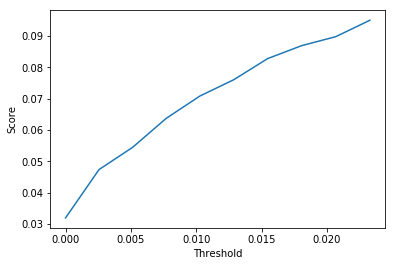

In [54]:
plt.plot(thresh, list_score)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.show()

## Grid search cv

In [55]:
param_grid = {
    'max_features':(None, 'sqrt')
    ,'max_depth':(None, 3, 6)
    #,'min_samples_split':(2,4,8)
    #,'min_samples_leaf':(4, 12, 16)
}
 
cv = GridSearchCV(clf, param_grid, cv=4, n_jobs=-1, scoring='roc_auc')
cv.fit(X_train, y_train)
 

cv.best_score_, cv.best_params_
# output:
# (0.82888870910162371, {'max_depth': 3, 'max_features': None})

(0.82138980483717083, {'max_depth': 3, 'max_features': 'sqrt'})

# xgboost

In [ ]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=9)
xg_cl.fit(X_train, y_train)
xgb_pred = xg_cl.predict_proba(X_test)

cv_params = {'max_depth': [3,5], 'min_child_weight': [1,3]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000,
              'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8,
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),
                            cv_params,
                             scoring = 'roc_auc', cv = 5, n_jobs = -1)

...

...

...

...

...

# Exploratory data analysis

Below is an exploration of the dataset. In order to create a predictive model it is useful to understand the dataset.

## Frequency tables

* Boolean: mean
* Numeric: describe
* Categorical: freqs

### Boolean columns

Use mean

In [15]:
df[cols_boolean].mean()*100

female                 42.695050
primary_bank_type_G    29.697474
contacted              64.944845
dtype: float64

### Numercal columns

Use describe and boxplot

In [16]:
df[cols_numeric].describe().round(1)

,monthly_income,existing_emi,loan_amount,loan_period,interest_rate,emi,age
count,69713.0,69662.0,42004.0,42004.0,22276.0,22276.0,69698.0
mean,5622.3,360.9,39430.0,3.9,19.2,1101.5,29.4
std,174767.1,2288.5,30727.6,1.2,5.8,752.7,14.9
min,0.0,0.0,5000.0,1.0,12.0,118.0,-49.0
25%,1650.0,0.0,20000.0,3.0,15.2,649.0,28.0
50%,2500.0,0.0,30000.0,4.0,18.0,941.0,31.0
75%,4000.0,350.0,50000.0,5.0,20.0,1295.0,35.0
max,38383838.3,545436.5,300000.0,6.0,37.0,13556.0,50.0


Conclusion: Must change age to be positive. 

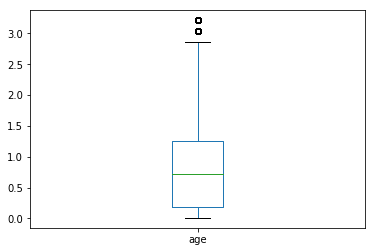

In [56]:
df[df.age>0].age.plot.box()

Below, the numeric columns are standardized.

In [57]:
# select numerical columns and standardize them
assert cols_numeric == df.columns[df.dtypes == 'float64'].tolist()

df[cols_numeric].apply(lambda x: (x - x.mean())/x.std()).describe().round(2) 

AssertionError: 

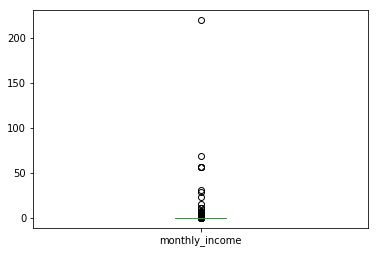

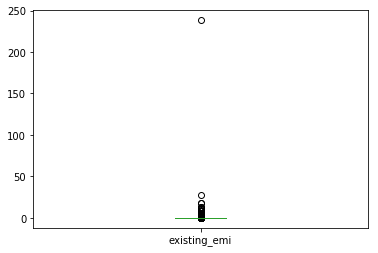

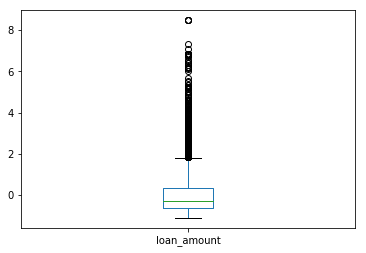

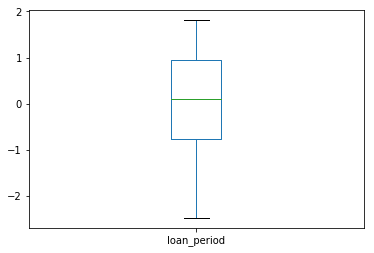

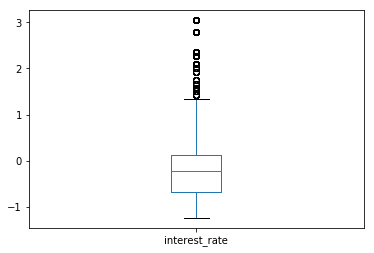

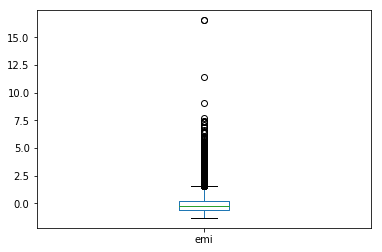

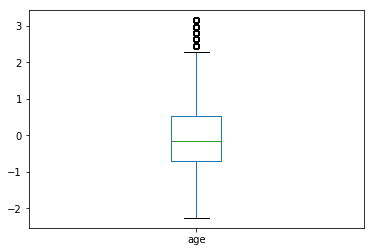

In [20]:
for col in cols_numeric:
    df[col].plot.box()
    plt.show()

qq how to handle outliers in emi and monthly income? logreg will be affected by them. maybe truncate with an upper value. 

qq if you us emonthly income then definately use truncate or somehting similar. 

### Categorical columns

Use freqs

In [21]:
# selec categorical cols and display freqs
for col in cols_category:
    print(freqs(df[col]))

city_code
nr unique: 678
frequency (%)
C10001    14.524159
C10002    12.650401
C10003    12.577831
C10004     8.480529
C10005     8.075589
C10006     6.100234
C10007     3.339671
C10008     2.104530
C10009     1.532678
C10010     1.396247
Name: city_code, dtype: float64 

None
city_category
nr unique: 3
frequency (%)
A    72.403083
C    16.972670
B    10.624247
Name: city_category, dtype: float64 

None
employer_code
nr unique: 36617
frequency (%)
COM0000002    0.695639
COM0000003    0.493188
COM0000004    0.398813
COM0000005    0.369891
COM0000006    0.296826
COM0000007    0.287693
COM0000009    0.232894
COM0000010    0.220717
COM0000013    0.202451
COM0000012    0.200929
Name: employer_code, dtype: float64 

None
employer_category1
nr unique: 3
frequency (%)
A    50.743588
B    27.484588
C    21.771824
Name: employer_category1, dtype: float64 

None
employer_category2
nr unique: 4
frequency (%)
4.0    88.025682
1.0     6.509210
2.0     2.988611
3.0     2.476496
Name: employer_categor

Conclusions:

city_code's top 3 cities have 14+12+12 percent.

city_category has 3 unique values. A is 72%

employer_code has too many uniwue. Not useful. Top frequency is < 1%. Don't use in modelling.

customer_existing_primary_bank_code's top 3 have 23+18+15 percent. 57 unique.
qq don't understand relation between this and primary_bank_type_g

source and source_category:
* are related. 
* source has 29 unque (with top 3 having 44+34+6 for S122+S133+S159), 
* source_category has 7 unique (with to 3 having 42+38+16 for B+G+C).
* To get actionable insight maybe source is useful - a marketer can then be more targeted. However, these two variables are probably correlated. 
*  Try using either one or the other. Using both is probably not good. 29 categories bind up many degrees of freedom. 
* Use df groupby ['source_category', 'source'].size() to understand this better. 

var1 is a secret variable with 5 unique values and have low class imbalance.

In [ ]:
cols_toomanyunique = ['city_code', 'employer_code']

In [ ]:
# df.groupby(['source_category', 'source']).size()
# conclusion: they are not as correlated as I thought 
# they don't measure the same thing because S122 show up in every source_category except A. 
# => can use both in a model

In [ ]:
source_top = ['S122', 'S133']
df[df.source.isin(source_top)].groupby(['source', 'source_category']).size()
# conclusion: s122 has mostly B and G. s133 has mostly b and c.

### Date columns

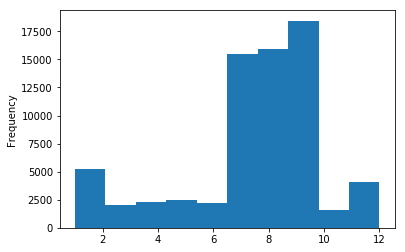

In [25]:
df['lead_creation_date'].dt.month.plot(kind='hist')
# concl: mostly months 7,8,9

In [26]:
# only year 2016
assert (df['lead_creation_date'].dt.year != 2016).sum() == 0

## NA 

In [27]:
# how many NA?
total_na = df.isnull().sum().sum()
total_cells =  df.count().sum()
total_na / total_cells * 100

12.335156077585149

fraction of NA per column:


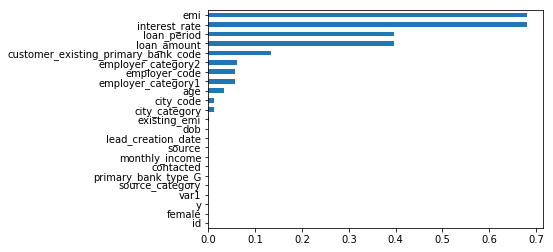

In [28]:
# fraction of NA per column
n = df.shape[0]
print("fraction of NA per column:")
(df.isnull().sum().sort_values(ascending=True) / n).plot.barh()

In [29]:
cols_nona = df.columns[(df.isnull().sum() == 0).values].tolist()
cols_nona.remove('id')
cols_nona.remove('y')
df[cols_nona].dtypes

lead_creation_date     datetime64[ns]
monthly_income                float64
contacted                        bool
source                       category
source_category              category
var1                         category
female                           bool
primary_bank_type_G              bool
dtype: object

## Group by

In [30]:
# y by source_category
df.groupby('source_category').size()

source_category
A        3
B    29812
C    11374
D      497
E     1050
F      459
G    26518
dtype: int64

In [31]:
tab1 = df.groupby('source_category').y.mean().sort_values()*100
print("percent of y=1, by", tab1)
# conclusion: source_category D and A never convert in our training set

percent of y=1, by source_category
A    0.000000
D    0.000000
C    1.230877
F    1.307190
G    1.372653
E    1.428571
B    1.660405
Name: y, dtype: float64


In [32]:
df.groupby('city_category').y.mean().sort_values()*100

city_category
C    0.803831
B    1.338798
A    1.655808
Name: y, dtype: float64

This is the end of EDA.

# 